# Demonstration of the step-by-step $\huge\sigma$-clipping using a [<i>celerite</i>](https://github.com/dfm/celerite) model

Based on the [example](https://github.com/dfm/celerite/blob/master/paper/figures/rotation/rotation.ipynb) from Foreman-Mackey ([2017](https://www.mendeley.com/catalogue/fast-scalable-gaussian-process-modeling-applications-astronomical-time-series/)). Written by [Pavel Sobolev](https://github.com/Paveloom) and located [here](https://github.com/Paveloom/C2).

Importing a standard module:

In [1]:
import re # Regular expression operations

Importing non-standard packages and modules:

[kplr](https://github.com/dfm/kplr) and [celerite](https://github.com/dfm/celerite) developed by [Daniel Foreman-Mackey](https://github.com/dfm) and other contributors;<br>
[matplotlib](https://github.com/matplotlib/matplotlib) developed by [Michael Droettboom](https://github.com/mdboom),  [Thomas Caswell](https://github.com/tacaswell) and other contributors;<br>
[autograd](https://github.com/HIPS/autograd) developed by [Dougal Maclaurin](https://dougalmaclaurin.com), [David Duvenaud](https://www.cs.toronto.edu/~duvenaud/), [Matt Johnson](http://people.csail.mit.edu/mattjj/), [Jamie Townsend](https://github.com/j-towns) and other contributors;<br>
[optimization](https://github.com/scipy/scipy/tree/master/scipy/optimize) module from [scipy](https://github.com/scipy/scipy) developed by contributors;<br>
[timeseries](https://github.com/astropy/astropy/tree/master/astropy/timeseries) module from [astropy](https://github.com/astropy/astropy) developed by contributors;<br>
[humanize](https://github.com/jmoiron/humanize) developed by [Jason Moiron](https://github.com/jmoiron) and other contributors.

In [2]:
import kplr # Tools for working with Kepler data

# Scalable 1D Gaussian Processes
import celerite # A model interface 
from celerite import terms # A kernel interface

from matplotlib import rcParams as rcP # Plot parameters
from matplotlib import pyplot as plt # 2D Plots

from autograd import numpy as np # Derivatives of numpy code

from scipy.optimize import OptimizeResult # A class containing optimization results
from scipy.optimize import minimize # Minimization of a scalar function

from astropy.timeseries import LombScargle # Computing of the Lomb-Scargle Periodogram

import humanize as hm # Ordinals

Setting plot parameters:

In [3]:
# A magic command to get inline plots within a Python Notebook
%matplotlib inline

# A magic command to enable 2x plots
%config IPython.matplotlib.backend = "retina"

# Setting the DPIs of figures
rcP["savefig.dpi"] = 300
rcP["figure.dpi"]  = 300

# Setting the Computer Modern Bright font
rcP["text.usetex"] = True
rcP["text.latex.preamble"] = r"\usepackage{cmbright}"

# Setting the font sizes
rcP["font.size"] = 16
rcP["legend.fontsize"] = 12

Loading sample data from the [Kepler Input Catalog](https://archive.stsci.edu/kepler/kic.html) (field descriptors are taken from [Kepler Archive Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/archive_manual.pdf)):

In [4]:
# The ID of a star from the Kepler Input Catalog
KIC_ID = 1430163

# Attaching the kplr API
client = kplr.API()

# Getting the star data
star = client.star(KIC_ID)

# Time values
t = []

# Pre-search Data Conditioning Simple Aperture Photometry (PDCSAP) flux values
f = []

# The 1-sigma errors in PDC flux values
ferr = []

# Getting long cadence data of light curves
for lc in star.get_light_curves(short_cadence=False):
    
    # Reading data from a light curve
    data = lc.read()
    
    # Getting time values from the data
    t0 = data["TIME"]
    
    # Getting PDCSAP flux values from the data
    f0 = data["PDCSAP_FLUX"]
    
    # Creating a mask for only qualitative data points
    mask = (data["SAP_QUALITY"] == 0) & np.isfinite(t0) & np.isfinite(f0)

    # Appending the qualitative time data to the existing list
    t.append(t0[mask])
    
    # Computing the median of the flux data
    mu = np.median(f0[mask])
    
    # Scaling the qualitative flux data and appending these to the existing list
    f.append( ( f0[mask] / mu - 1.0 ) * 1e3 )
    
    # Scaling the qualitative flux errors data and appending these to the existing list
    ferr.append( data["PDCSAP_FLUX_ERR"][mask] / mu * 1e3 )
    
# Concatenating the arrays within the lists

t = np.concatenate(t)
f = np.concatenate(f)
ferr = np.concatenate(ferr)

# Getting contiguous arrays

t = np.ascontiguousarray(t, dtype = float)
f = np.ascontiguousarray(f, dtype = float)
ferr = np.ascontiguousarray(ferr, dtype = float)

Making a first guess at the period using the Lomb-Scargle periodogram (see, e.g VanderPlas ([2017](https://www.mendeley.com/catalogue/understanding-lombscargle-periodogram-1/))) and comparing it to the real value known from Mathur et al. ([2014](https://www.mendeley.com/catalogue/investigating-magnetic-activity-f-stars-kepler-mission/)):

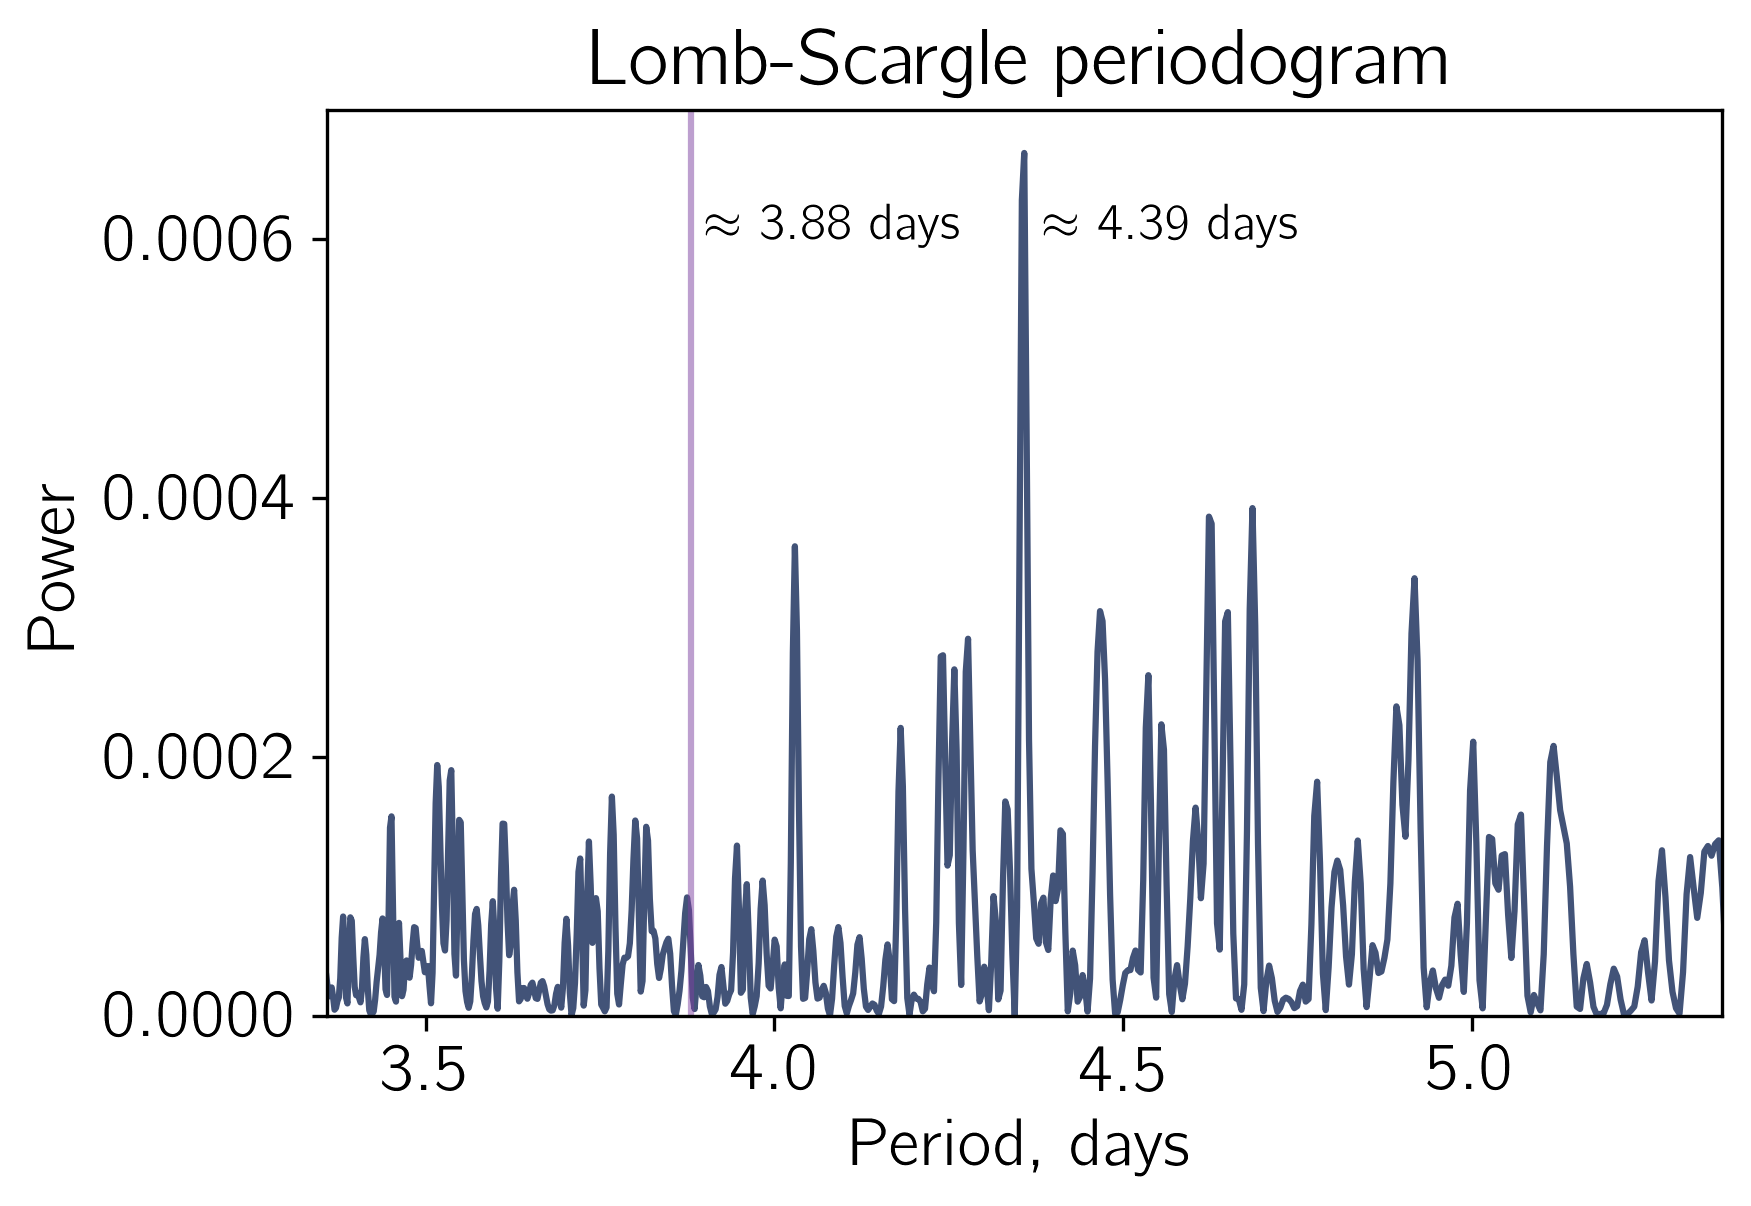

In [5]:
# Creating a set of evenly spaced frequencies 
freq = np.linspace(1e-1, 1.0, 5000)

# Getting the PSD-normalized Lomb-Scargle power spectrum of the data using the fast method (O[N log N])
power = LombScargle(t, f).power(freq, method="fast", normalization="psd")

# Determining the maximum peak
period = 1.0 / freq[np.argmax(power)]

# Scaling the output
power /= len(t)

# Plotting the result with emphasis on the period value
# and comparing it to the real value

## Plotting data
plt.plot(1.0 / freq, power, color="#425378")

## Marking the true period value
plt.axvline(3.88, color="#7C40A0", alpha=0.5)

## Adding approximate period values on the plot
plt.text(3.9, 0.0006, r"$\approx$ 3.88 days", fontsize=12)
plt.text(4.385, 0.0006, r"$\approx$ 4.39 days", fontsize=12)

## Setting axis limits
plt.xlim(period - 1, period + 1)
plt.ylim(0, 0.0007)

## Setting labels
plt.xlabel("Period, days")
plt.ylabel("Power")
plt.title("Lomb-Scargle periodogram")

## Saving the figure
plt.savefig("figures/LSPeriodogram", bbox_inches="tight")

## Showing the result
plt.show()

## Closing the plot
plt.close()

Taking a subset of the data (here: quarters [4](https://archive.stsci.edu/kepler/preview.php?type=lc&dsn=KPLR001430163-2010078095331) and [5](https://archive.stsci.edu/kepler/preview.php?type=lc&dsn=KPLR001430163-2010174085026) of the long cadence data):

In [6]:
# Defining a mask with time bounds
mask = (t >= 352.396596505) & (t <= 537.5502295)

# Taking the subset
t = t[mask]
f = f[mask]
ferr = ferr[mask]

Defining the covariance function as described in the example from Foreman-Mackey ([2017](https://www.mendeley.com/catalogue/fast-scalable-gaussian-process-modeling-applications-astronomical-time-series/)):
replicating the properties of

$ \LARGE k(\tau) = A \exp\left( - \frac{\tau^2}{2 l^2} - \Gamma \sin^2\left( \frac{\pi \tau}{P_{rot}} \right) \right)$

by constructing a simple <i>celerite</i> covariance function

$ \LARGE k(\tau) = \frac{a}{2 + b} e^{-c\tau} \left[ \cos\left( \frac{2 \pi \tau}{P} \right) + (1 + b) \right] $

The parameters are defined by logarithms in the code for the simplicity of specifying priors. 

In [7]:
# Defining the custom kernel
class RotationTerm(terms.Term):
    """
    
    A subclass describing the celerite covariance function
    used in the Example 3 in Foreman-Mackey (2017)
    
    """
    
    # Defining the parameter names
    parameter_names = ("log_a", "log_b", "log_c", "log_p")

    def get_real_coefficients(self, params):
        """
        
        An overloading method for ``get_real_coefficients``
        
        Parameters:
            params: An array containing values of the parameters
            
        Returns:
            A list of real coefficients
        
        """
        
        # Getting the values of the parameters
        log_a, log_b, log_c, log_p = params
        
        # Computing ``b``
        b = np.exp(log_b)
        
        return (
            np.exp(log_a) * (1.0 + b) / (2.0 + b),
            np.exp(-log_c),
        )

    def get_complex_coefficients(self, params):
        """
        
        An overloading method for ``get_complex_coefficients``
        
        Parameters:
            params: An array containing values of the parameters
            
        Returns:
            A list of complex coefficients
        
        """
        
        # Getting the values of the parameters
        log_a, log_b, log_c, log_p = params
        
        # Computing ``b``
        b = np.exp(log_b)
        
        return (
            np.exp(log_a) / (2.0 + b),
            0.0,
            np.exp(-log_c),
            2 * np.pi * np.exp(-log_p),
        )

Specifying the values and the priors of the parameters according to the [example](https://github.com/dfm/celerite/blob/master/paper/figures/rotation/rotation.ipynb) and to the Table 3 from Foreman-Mackey ([2017](https://www.mendeley.com/catalogue/fast-scalable-gaussian-process-modeling-applications-astronomical-time-series/)) respectively:

In [8]:
# Defining the priors
bounds = dict(log_a=(-10.0, 0.0), log_b=(-5.0, 5.0), log_c=(1.5, 5.0), log_p=(-3.0, 5.0))

# Building a kernel
kernel = RotationTerm(
    log_a = np.log(np.var(f)),
    log_b = np.log(1.0),
    log_c = np.log(10.0),
    log_p = np.log(period),
    bounds = bounds
)

Building a <i>celerite</i> model with the specified kernel; defining the functions 
for computing negative marginalized log likelihood:

In [9]:
# Building a celerite model with the specified kernel
gp = celerite.GP(kernel, mean=np.median(f))

def neg_log_like(params, y, model, m):
    """
    
    A function to get negative marginalized log likelihood
    
    Parameters:
        params: An array containing parameter values;
        y : An array of data;
        model : A celerite model;
        m : A mask for an array of data
        
    Returns:
        The negative marginalized log likelihood
        
    """
    
    # Setting parameter values to the given vector
    model.set_parameter_vector(params)

    # Computing and returning the result
    return -model.log_likelihood(y[m])

def grad_neg_log_like(params, y, model, m):
    """
    
    A function to get the gradient of
    the negative marginalized likelihood 
    
    Parameters:
        params: An array containing parameter values;
        y : An array of data;
        model : A celerite model;
        m : A mask for an array of data
    
    Returns:
        The gradient of the negative
        marginalized likelihood
        
    """
    
    # Setting parameter values to the given vector
    model.set_parameter_vector(params)
    
    # Computing and returning the result
    return -model.grad_log_likelihood(y[m])[1]

Specifying the initial variables and defining the supportive functions for step-by-step $\Large\sigma$-clipping:

In [10]:
# Getting the values of the initial parameters
init_params = gp.get_parameter_vector()

# Getting the names of the parameters
params_names = [re.sub(r".*:", "", name) for name in gp.get_parameter_names()]

# Getting bounds values
bounds_values = gp.get_parameter_bounds()

# Creating an initial mask
sigma_mask = np.ones(len(t), dtype=bool)

# Defining a supportive function for printing out collected results
def print_step():
    """
    
    A function which prints / plots the following
    info collected during a step of the sigma clipping:
    — The solution of an optimization;
    — The plot of the residuals from subtraction of
      conditional predictive distribution of the model
      from the input data.
    
    """
    
    # Printing the solution of an optimization
    
    if opt.success:
        print("The solution of the optimization:\n")
        
        for i in range(len(params_names)):
            print(params_names[i] + ":", opt.x[i])
            
        print()
            
    else:
        print("The optimizer did not exit successfully.\n")
        print("The message:")
        
        print(opt.message)
        
        print()
        
    # Plotting the residuals
    plt.plot(t[sigma_mask], rds[sigma_mask], ".", color="#7C40A0")
    
    # Plotting the sigma bounds
    plt.plot(t[sigma_mask], rds[sigma_mask] + sig[sigma_mask], "_", color="#425378", lw="0.01")
    plt.plot(t[sigma_mask], rds[sigma_mask] - sig[sigma_mask], "_", color="#425378", lw="0.01")
    
    # Plotting the lines where the values of ``new_sigma_mask`` are False
    for j in range(len(sigma_mask)):
        if sigma_mask[j] and not new_sigma_mask[j]:
            plt.axvline(t[j], color="#FFDB68", alpha=0.5)
    
    # Setting labels
    plt.xlabel("Time, days")
    plt.ylabel("Flux with " + str(sig_factor) + "$\sigma$ bounds")
    
    # Setting title
    plt.title("Residuals on the " + hm.ordinal(k) + " step")
    
    # Showing the result
    plt.show()
    
    # Saving the figure
    plt.savefig("figures/F" + str(sig_factor) + "_S" + str(k), bbox_inches="tight")
    
    # Closing the plot
    plt.close()

Step-by-step $\Large\sigma$-clipping with the <i>sig_factor</i> being equal 1:

1st step:

The solution of the optimization:

log_a: -2.1121901868034345
log_b: -5.0
log_c: 1.5
log_p: 1.3322861105349642

2nd step:

The solution of the optimization:

log_a: -2.368922931898604
log_b: -5.0
log_c: 1.5
log_p: 1.2908781873875705

3rd step:

The solution of the optimization:

log_a: -2.5059100652512902
log_b: -5.0
log_c: 1.5
log_p: 1.2709396340928056

4th step:

The solution of the optimization:

log_a: -2.5782061913943113
log_b: -5.0
log_c: 1.5
log_p: 1.2597976792336534

5th step:

The solution of the optimization:

log_a: -2.6171634421658245
log_b: -5.0
log_c: 1.5
log_p: 1.254340924803434

6th step:

The solution of the optimization:

log_a: -2.635484453061345
log_b: -5.0
log_c: 1.5
log_p: 1.252291607722975

7th step:

The solution of the optimization:

log_a: -2.644129079895658
log_b: -5.0
log_c: 1.5
log_p: 1.2528431825982431

8th step:

The solution of the optimization:

log_a: -2.647665222810628
log_b: -5.0
log_c: 1.5
log_p: 1.2525172545236083

9th step:

The solutio

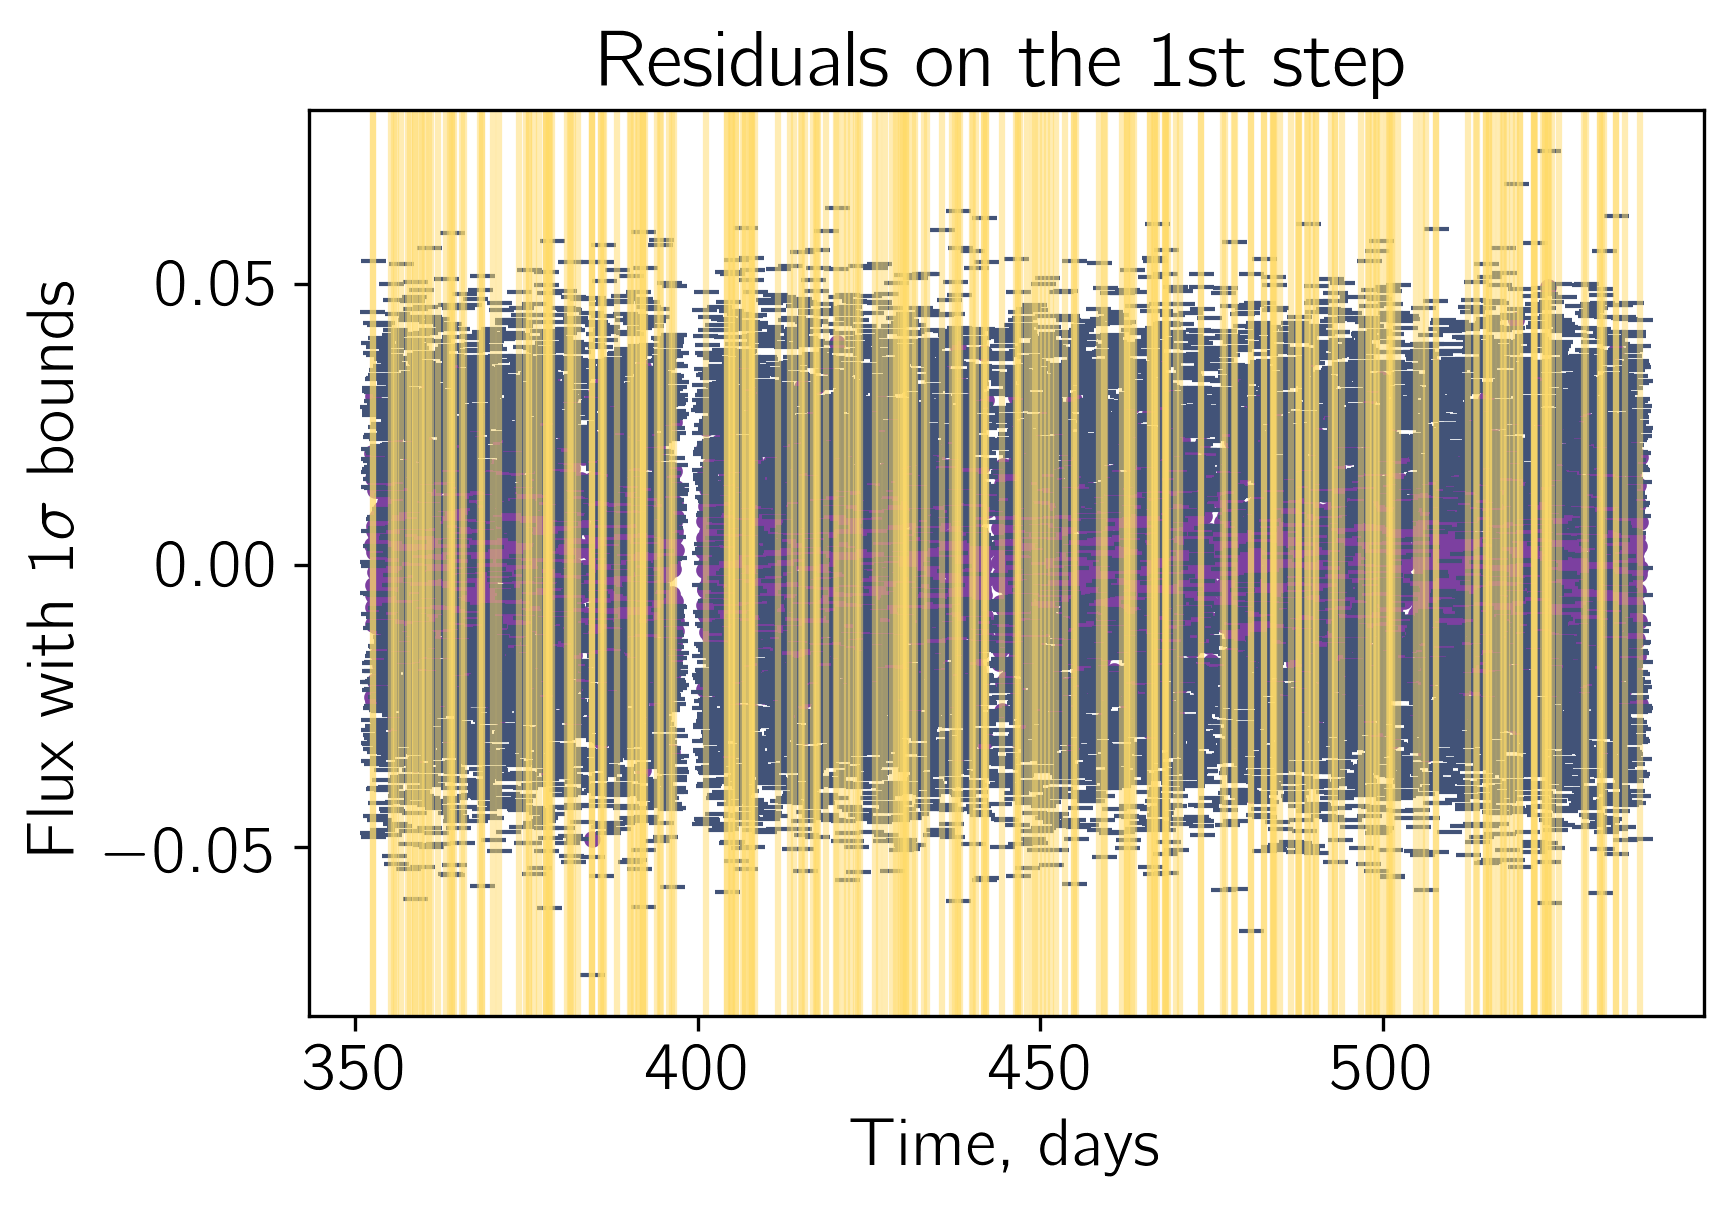

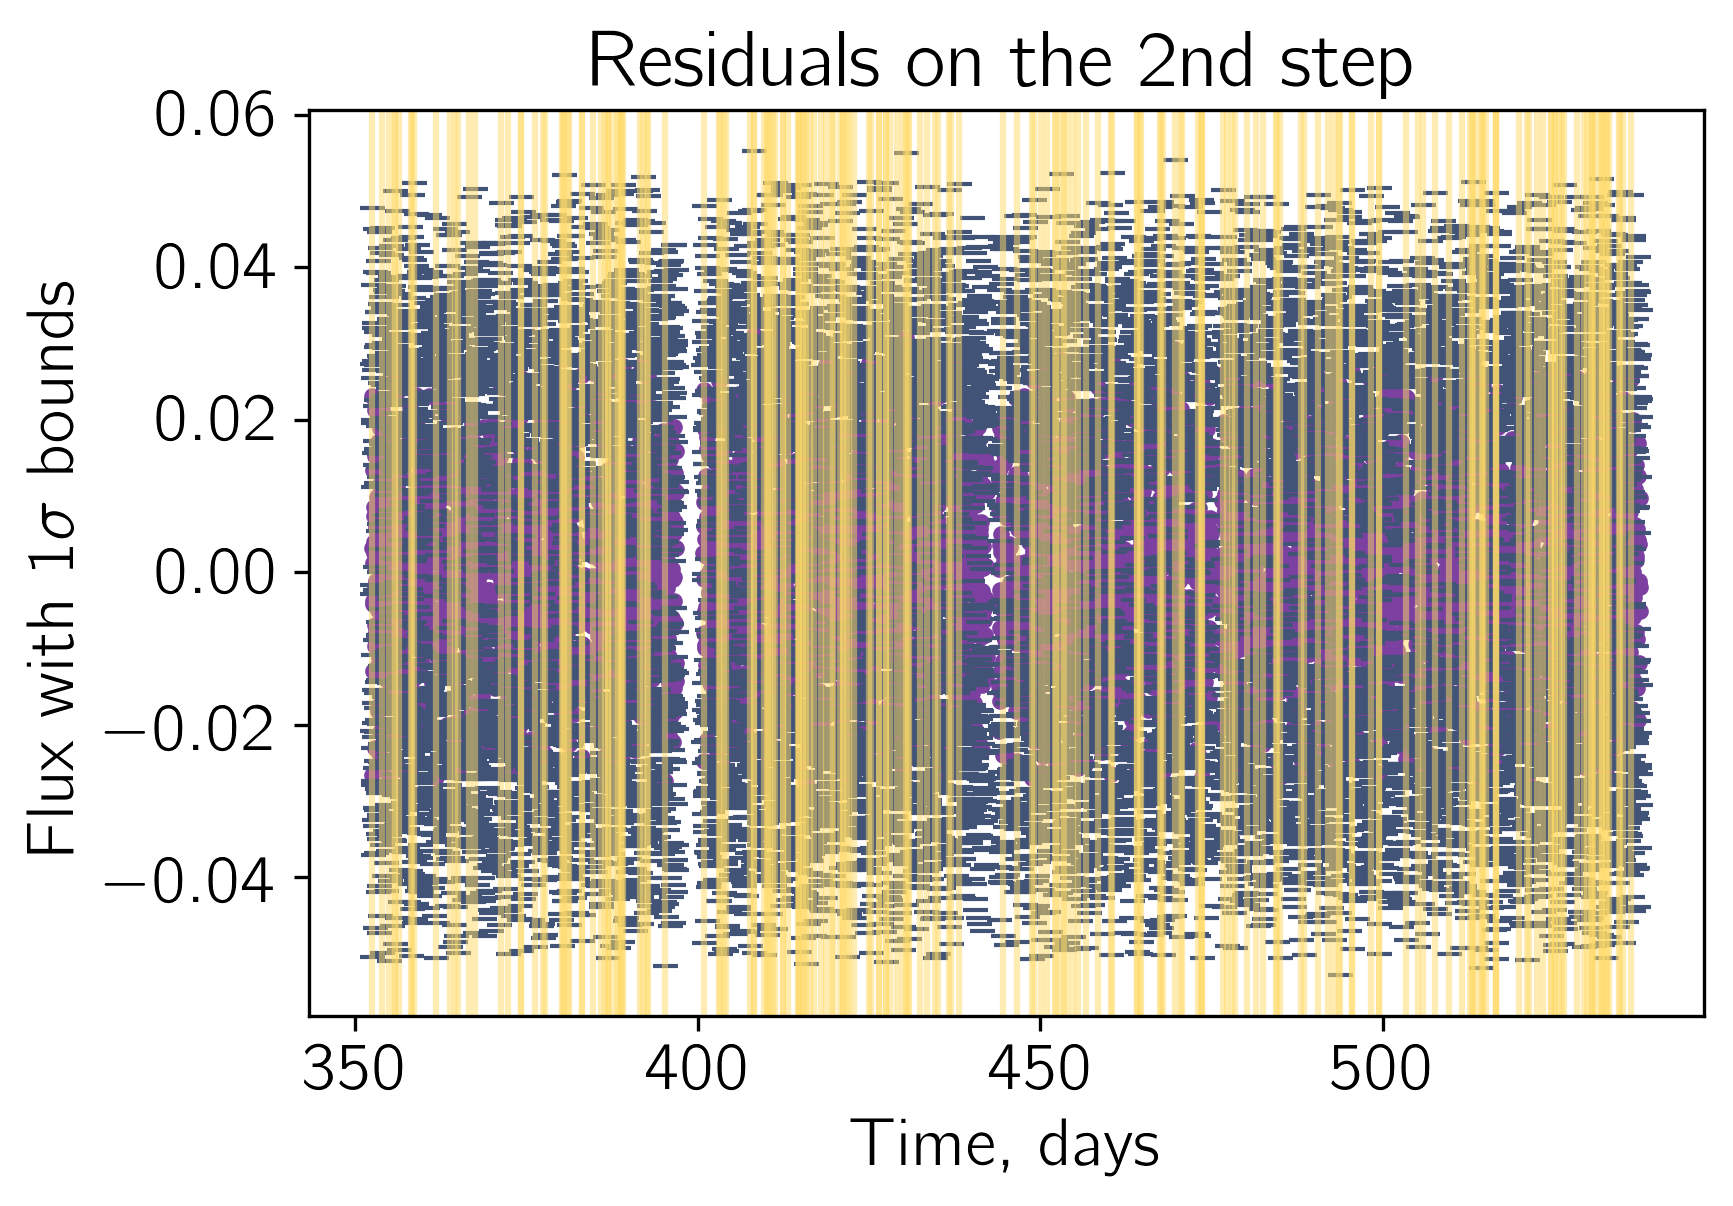

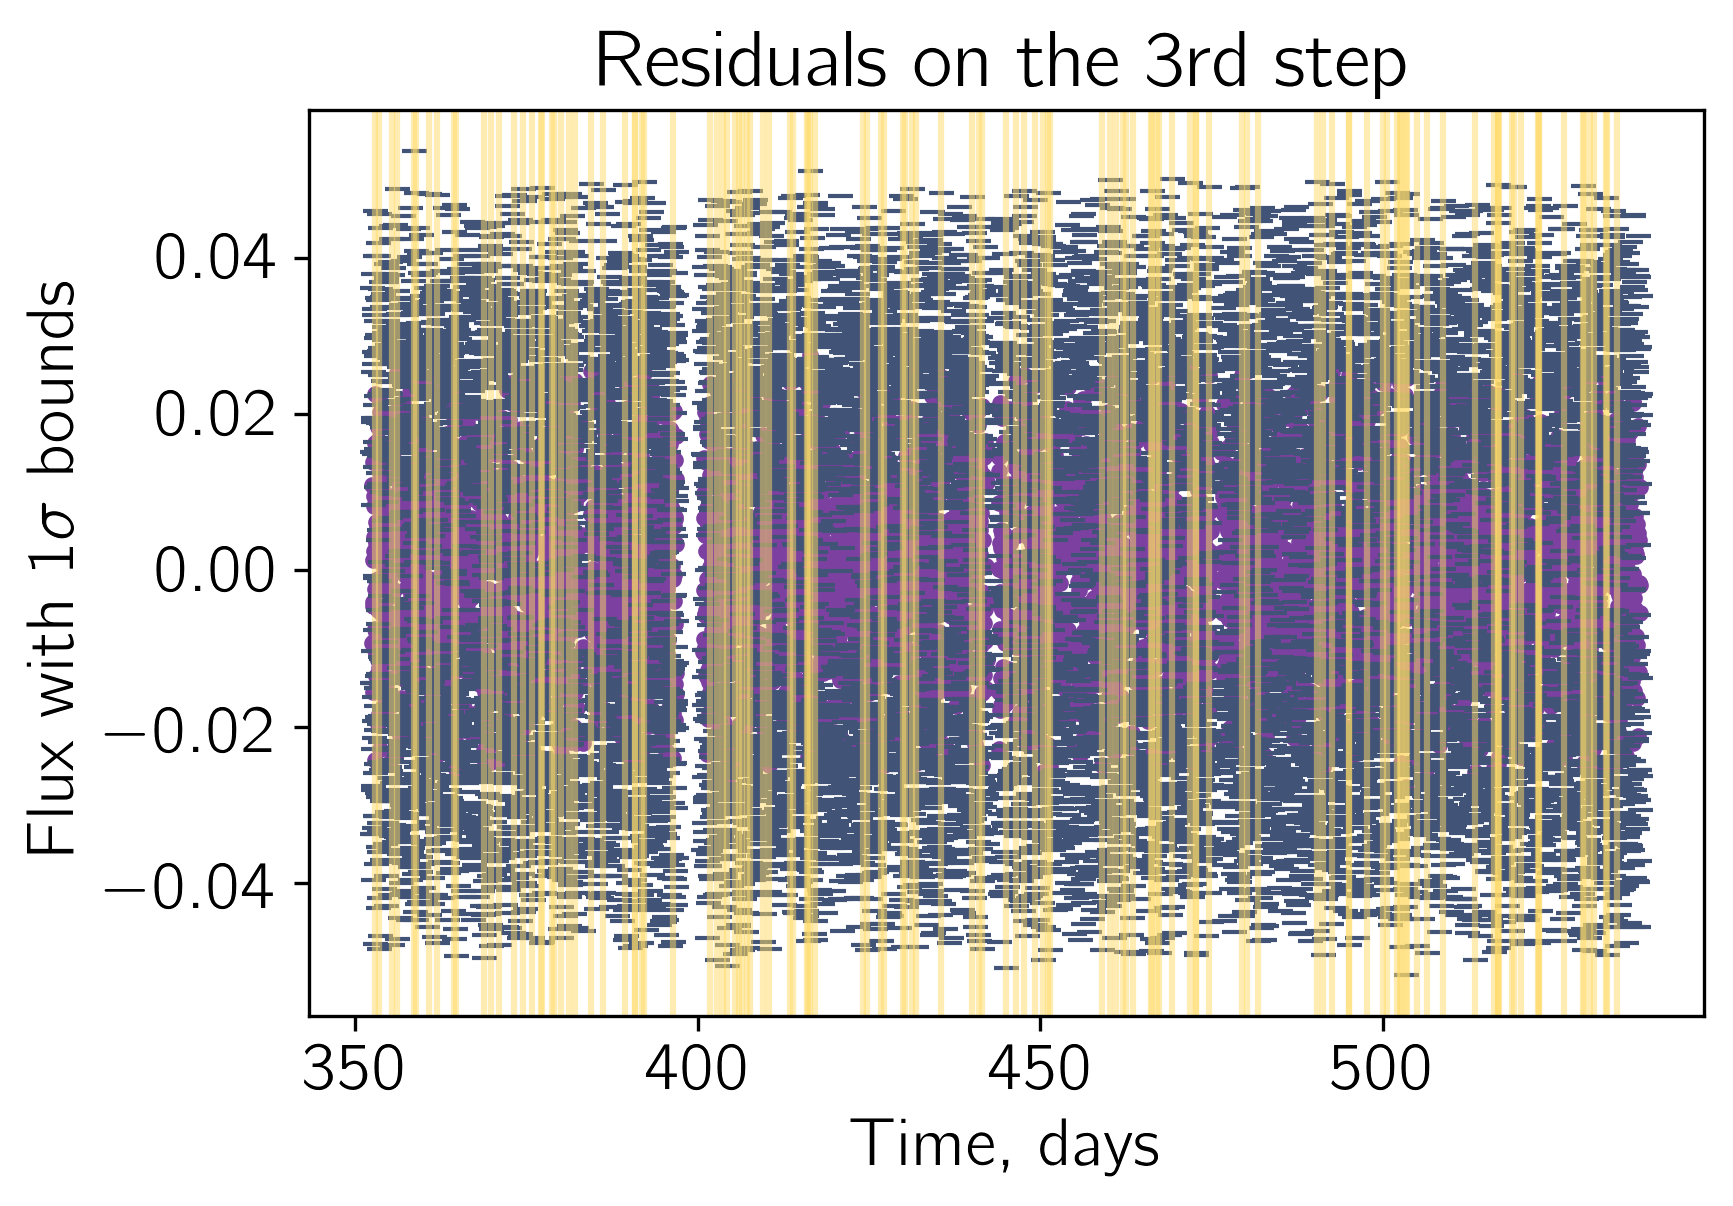

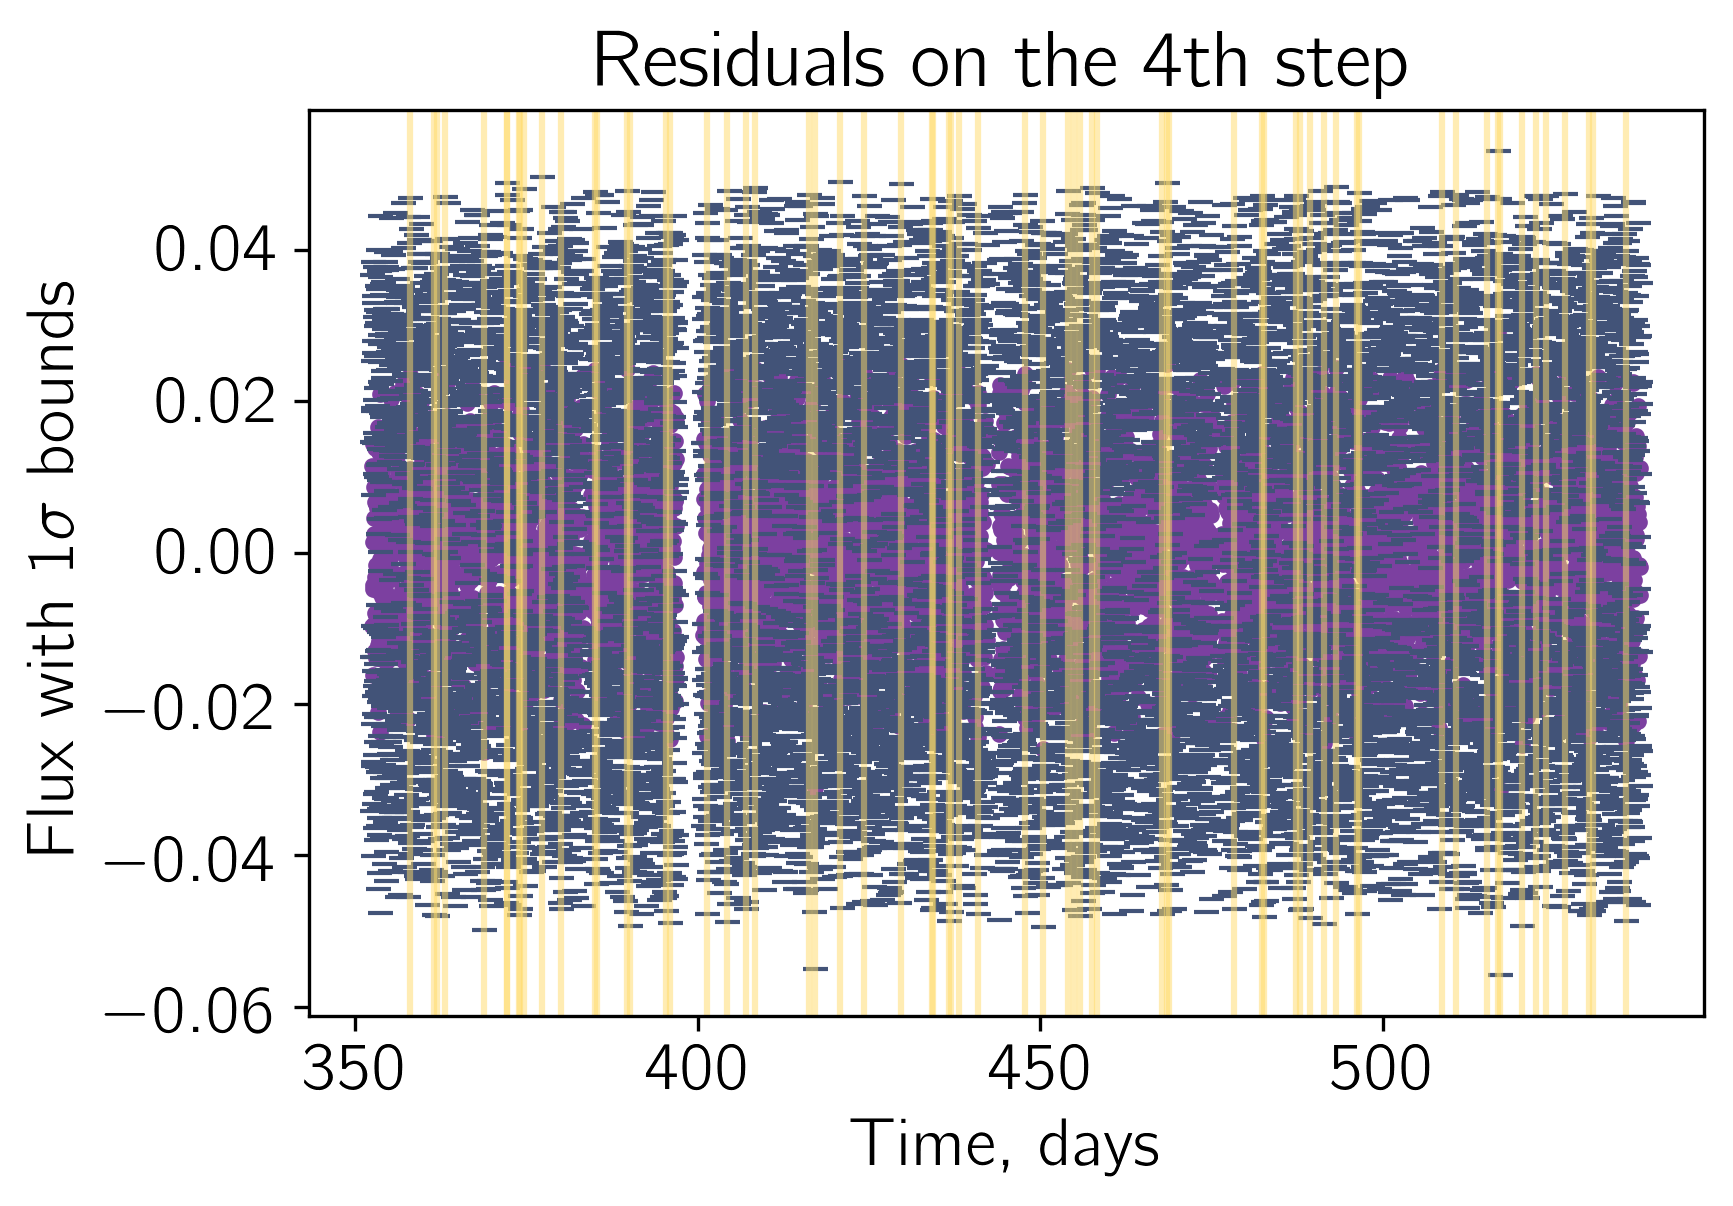

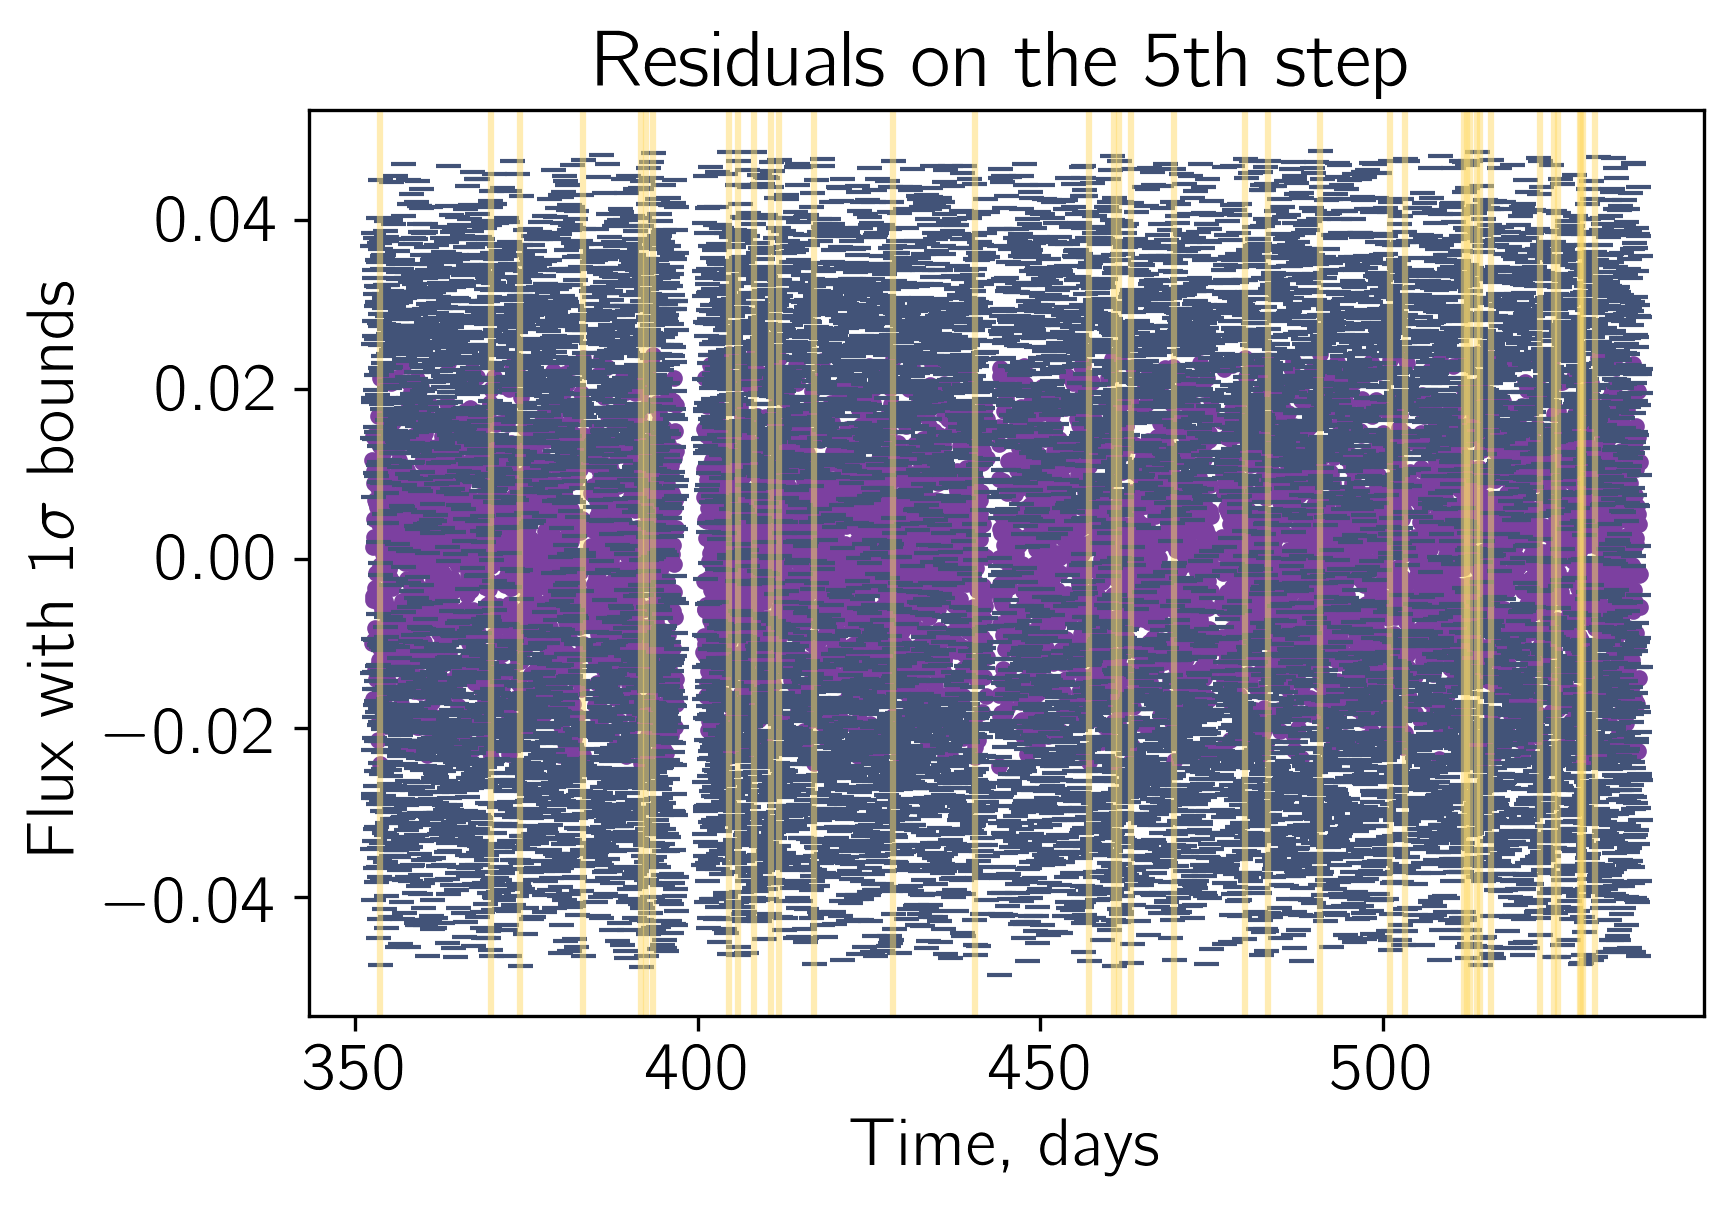

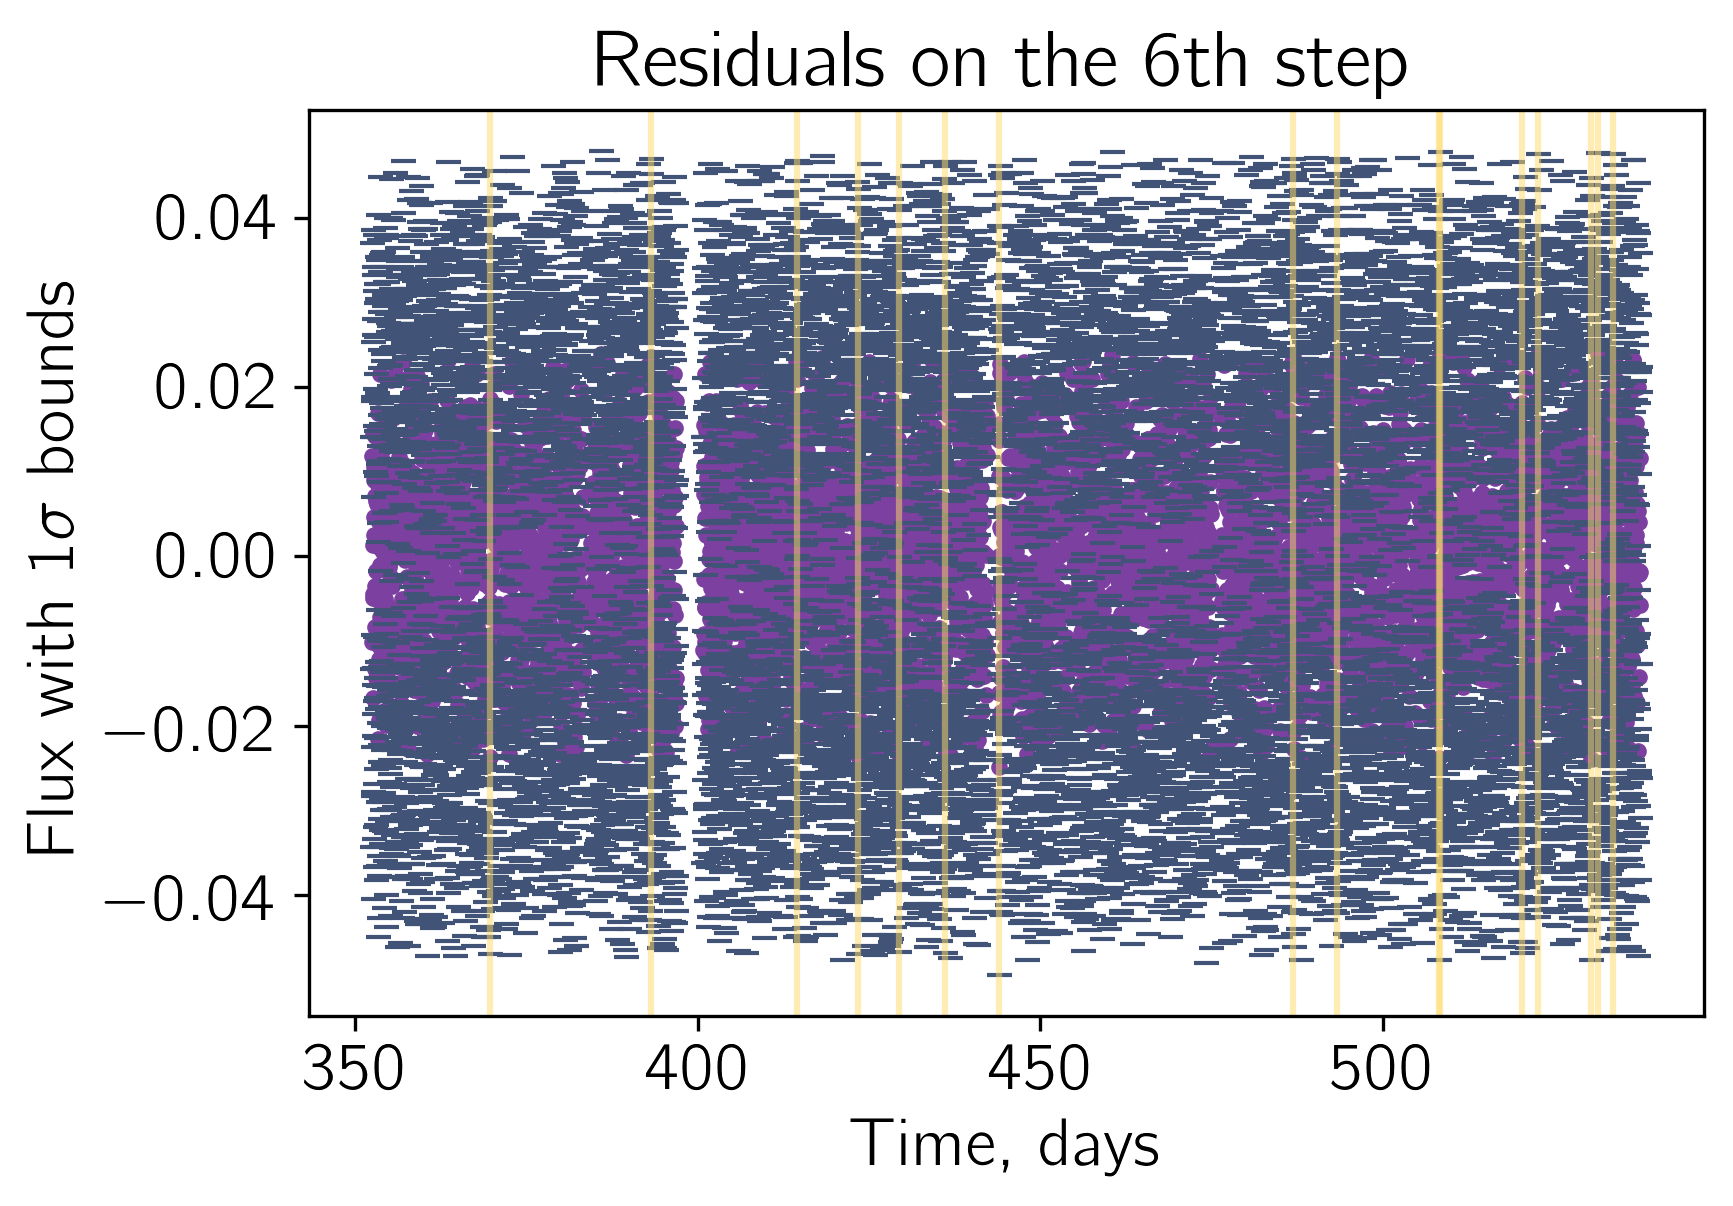

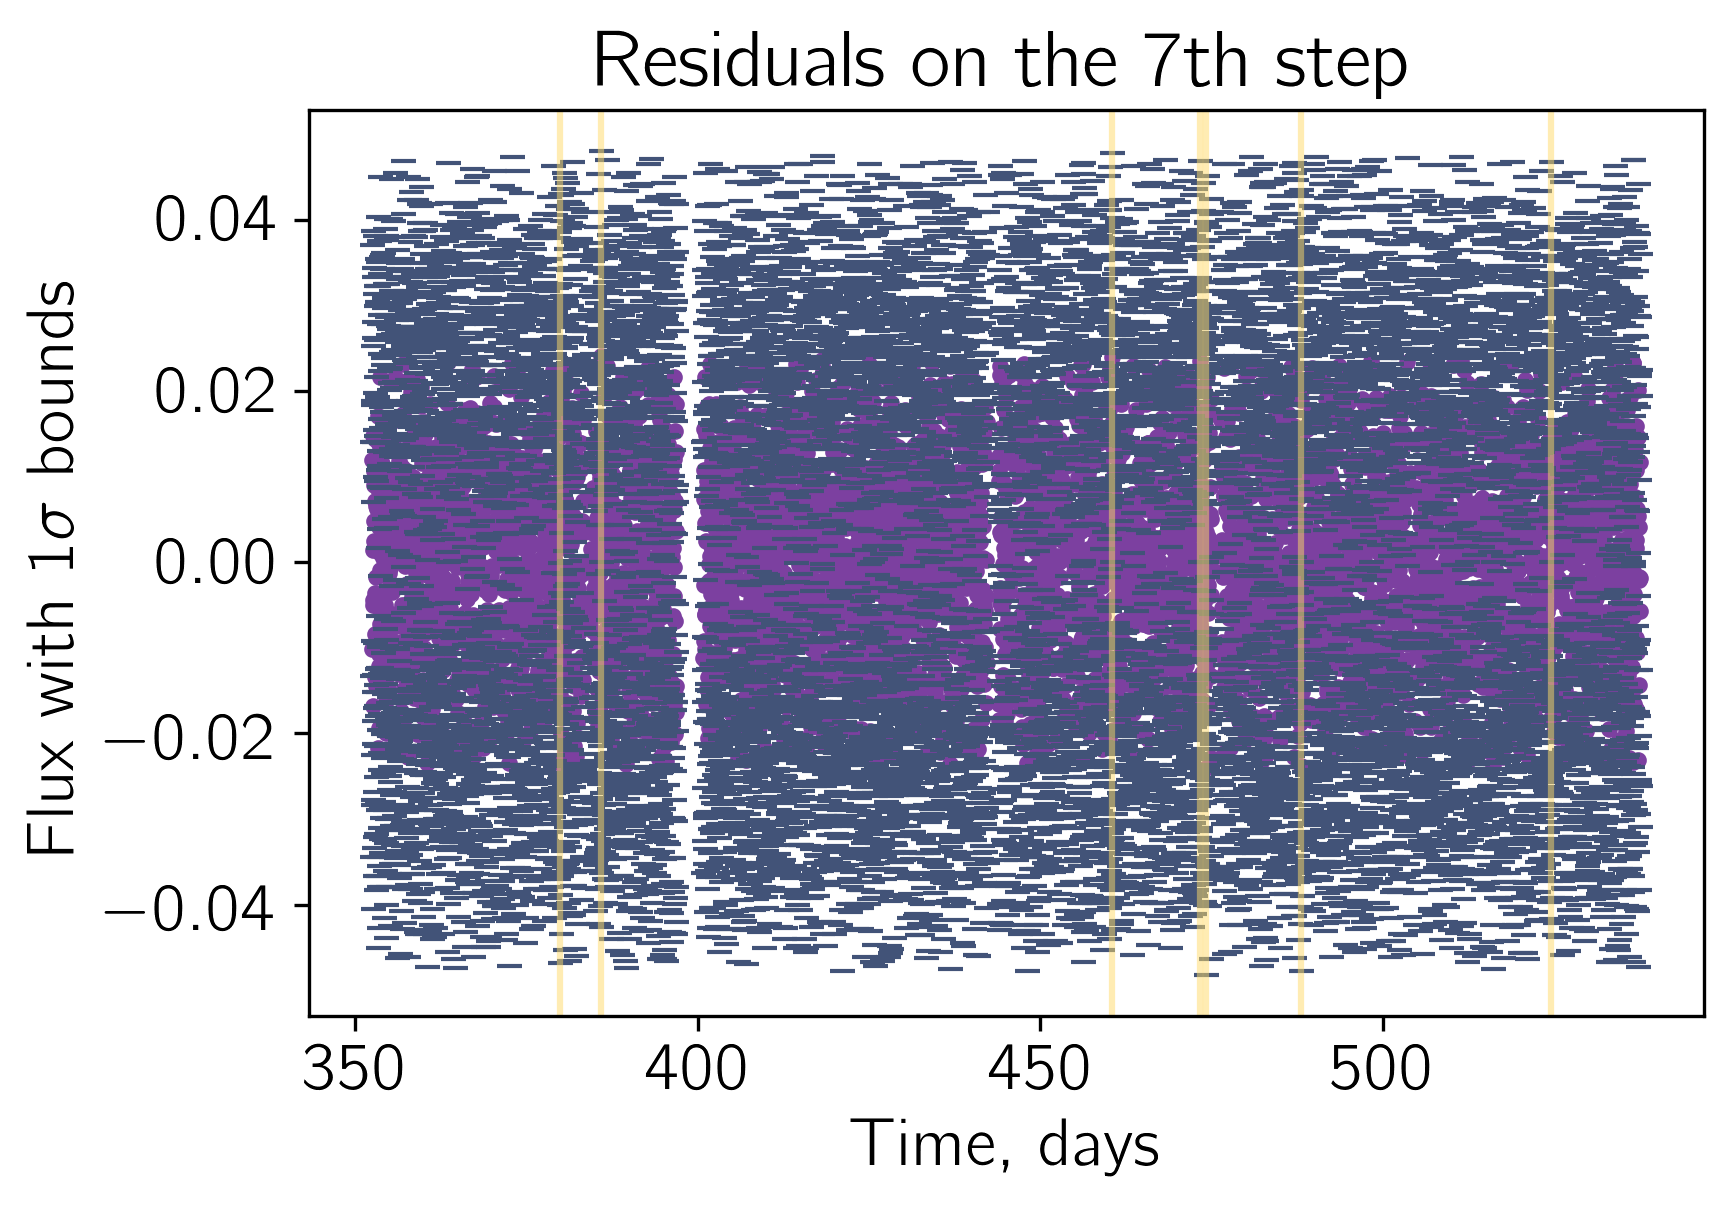

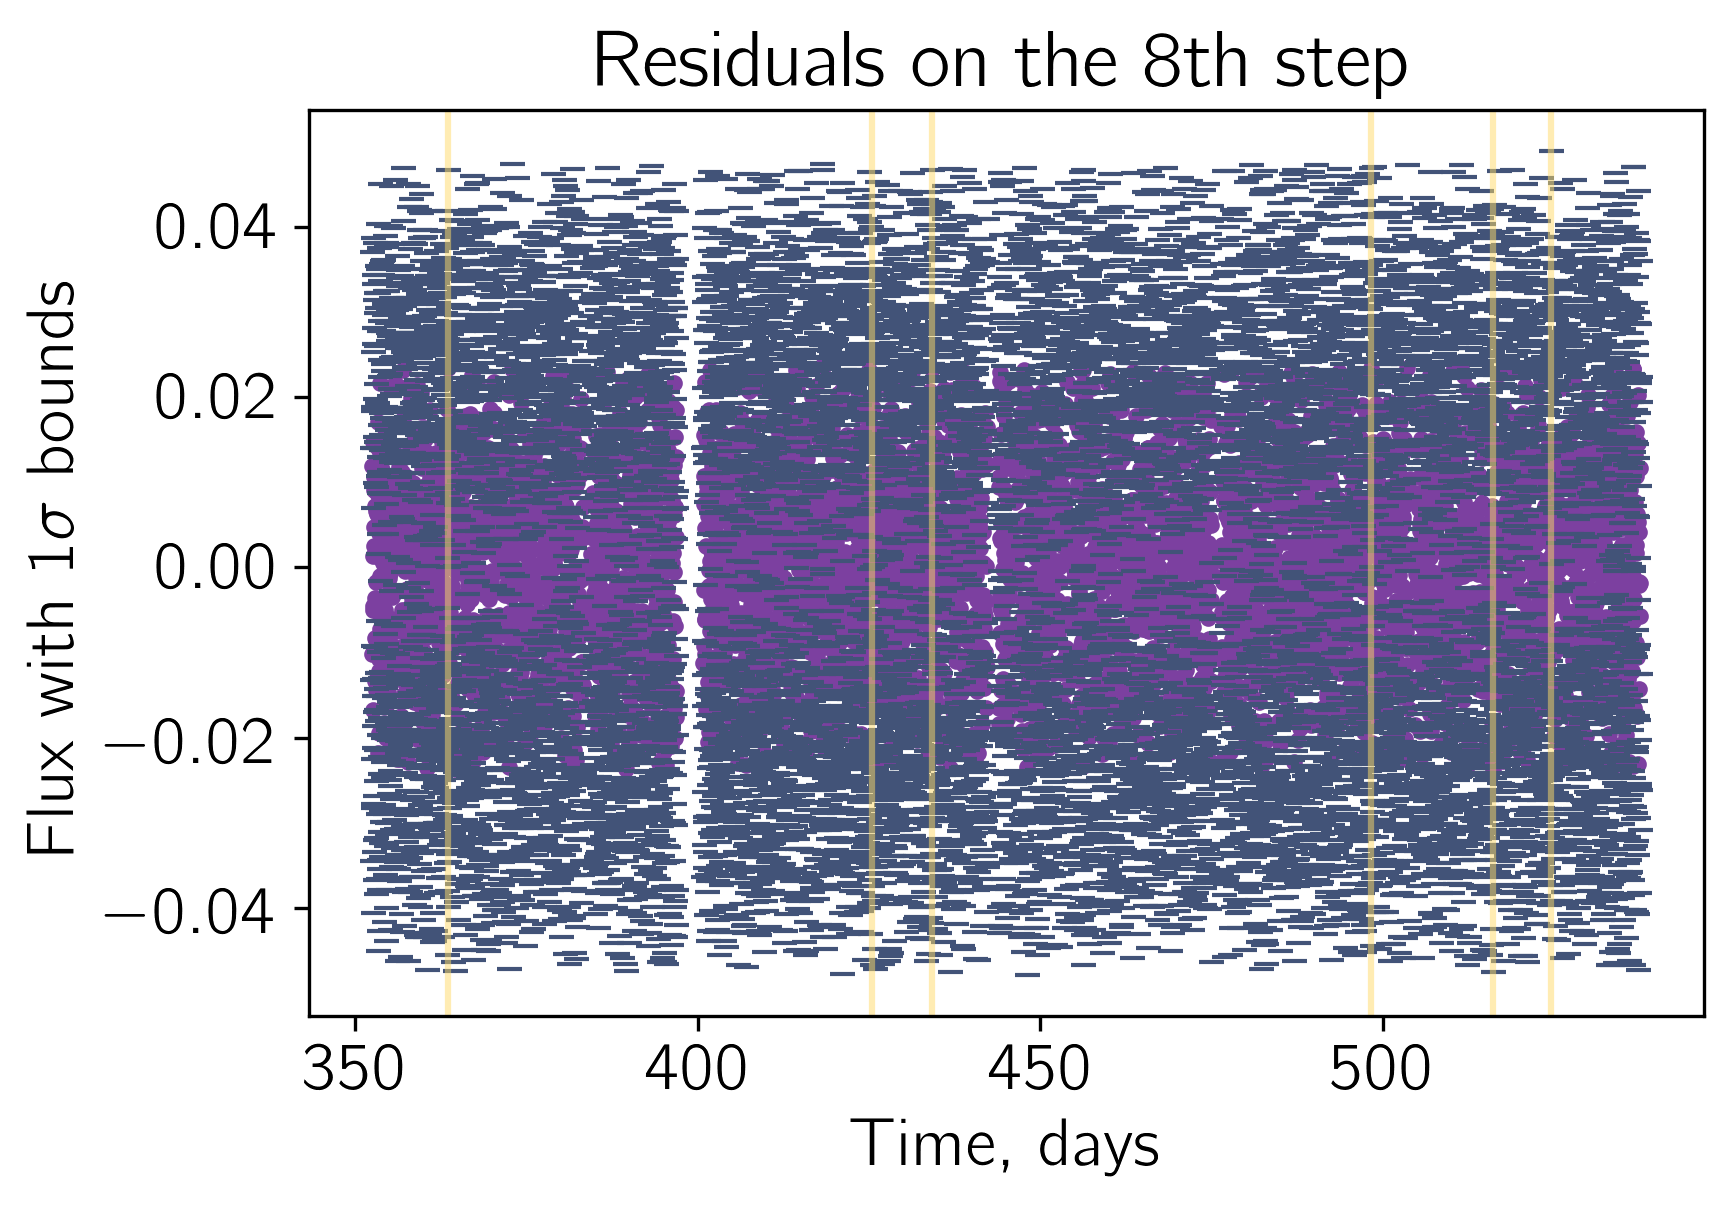

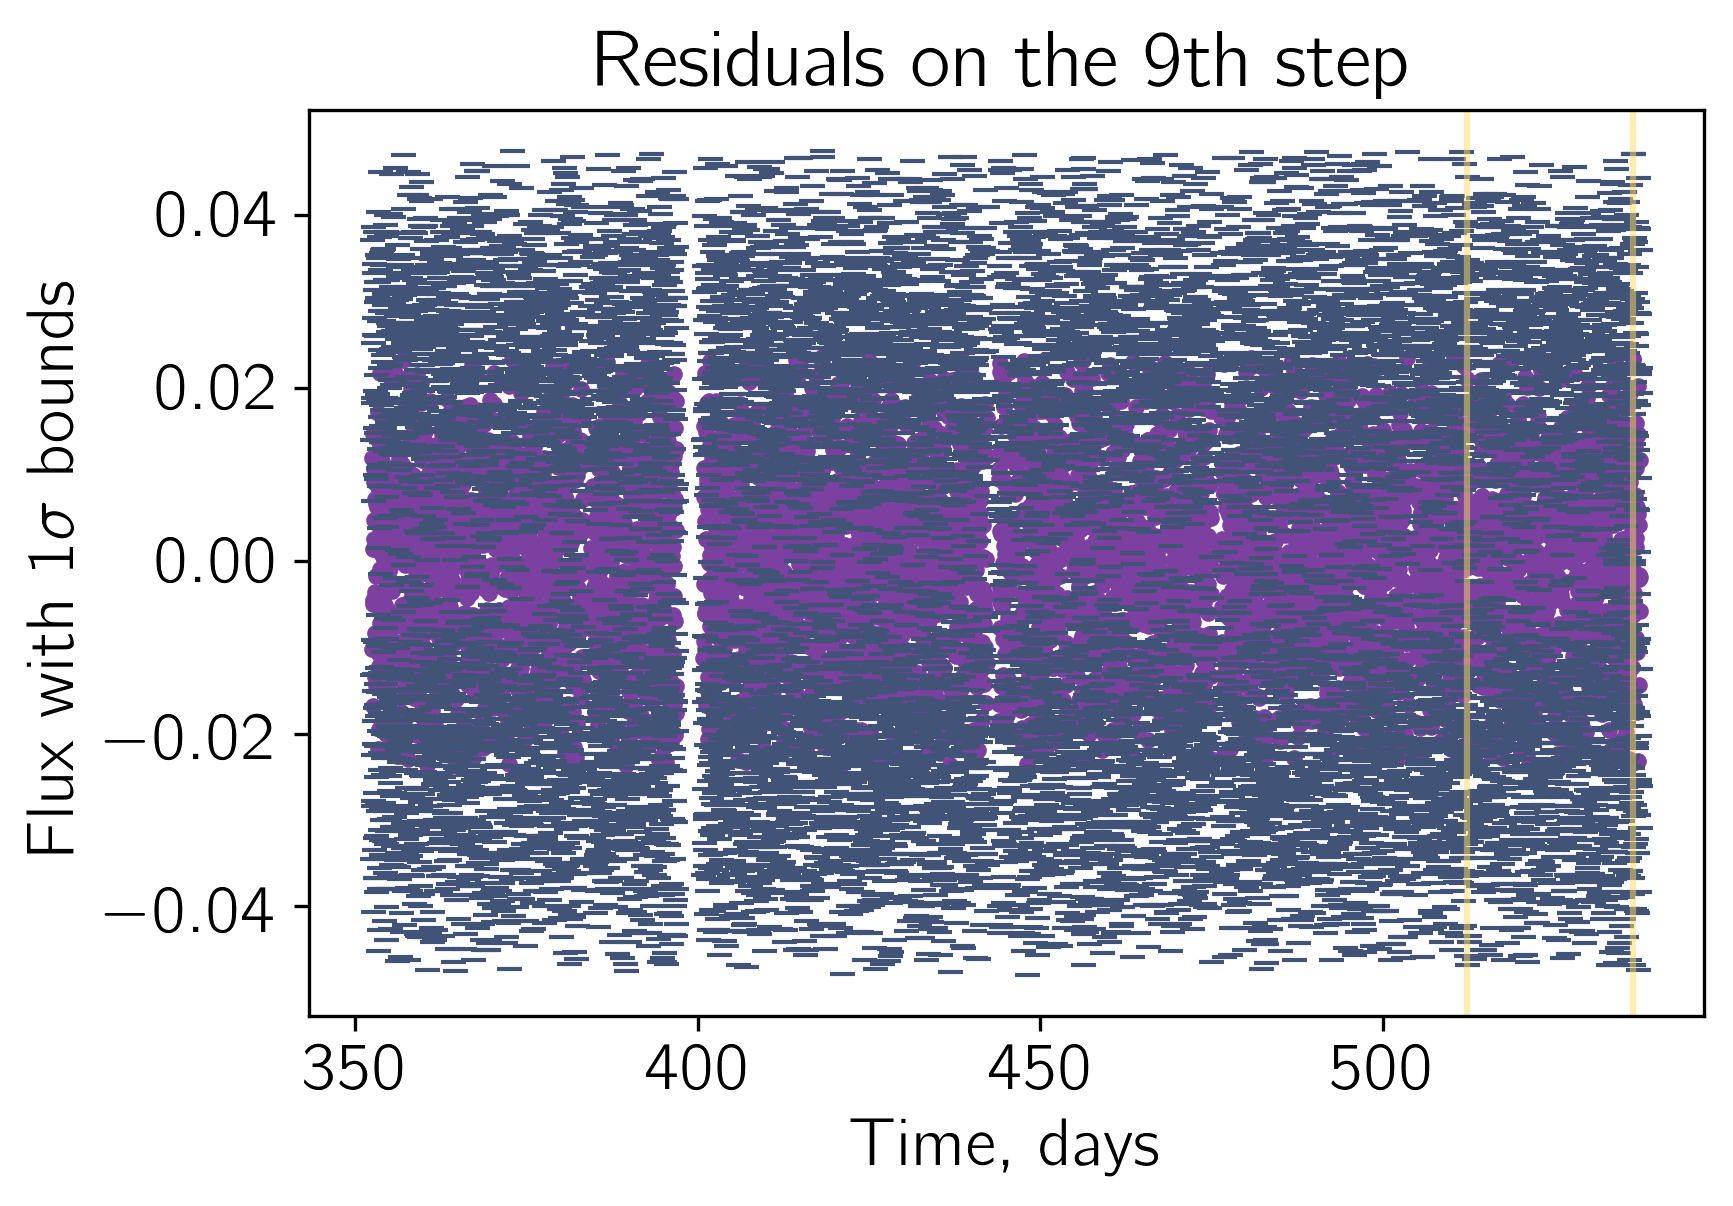

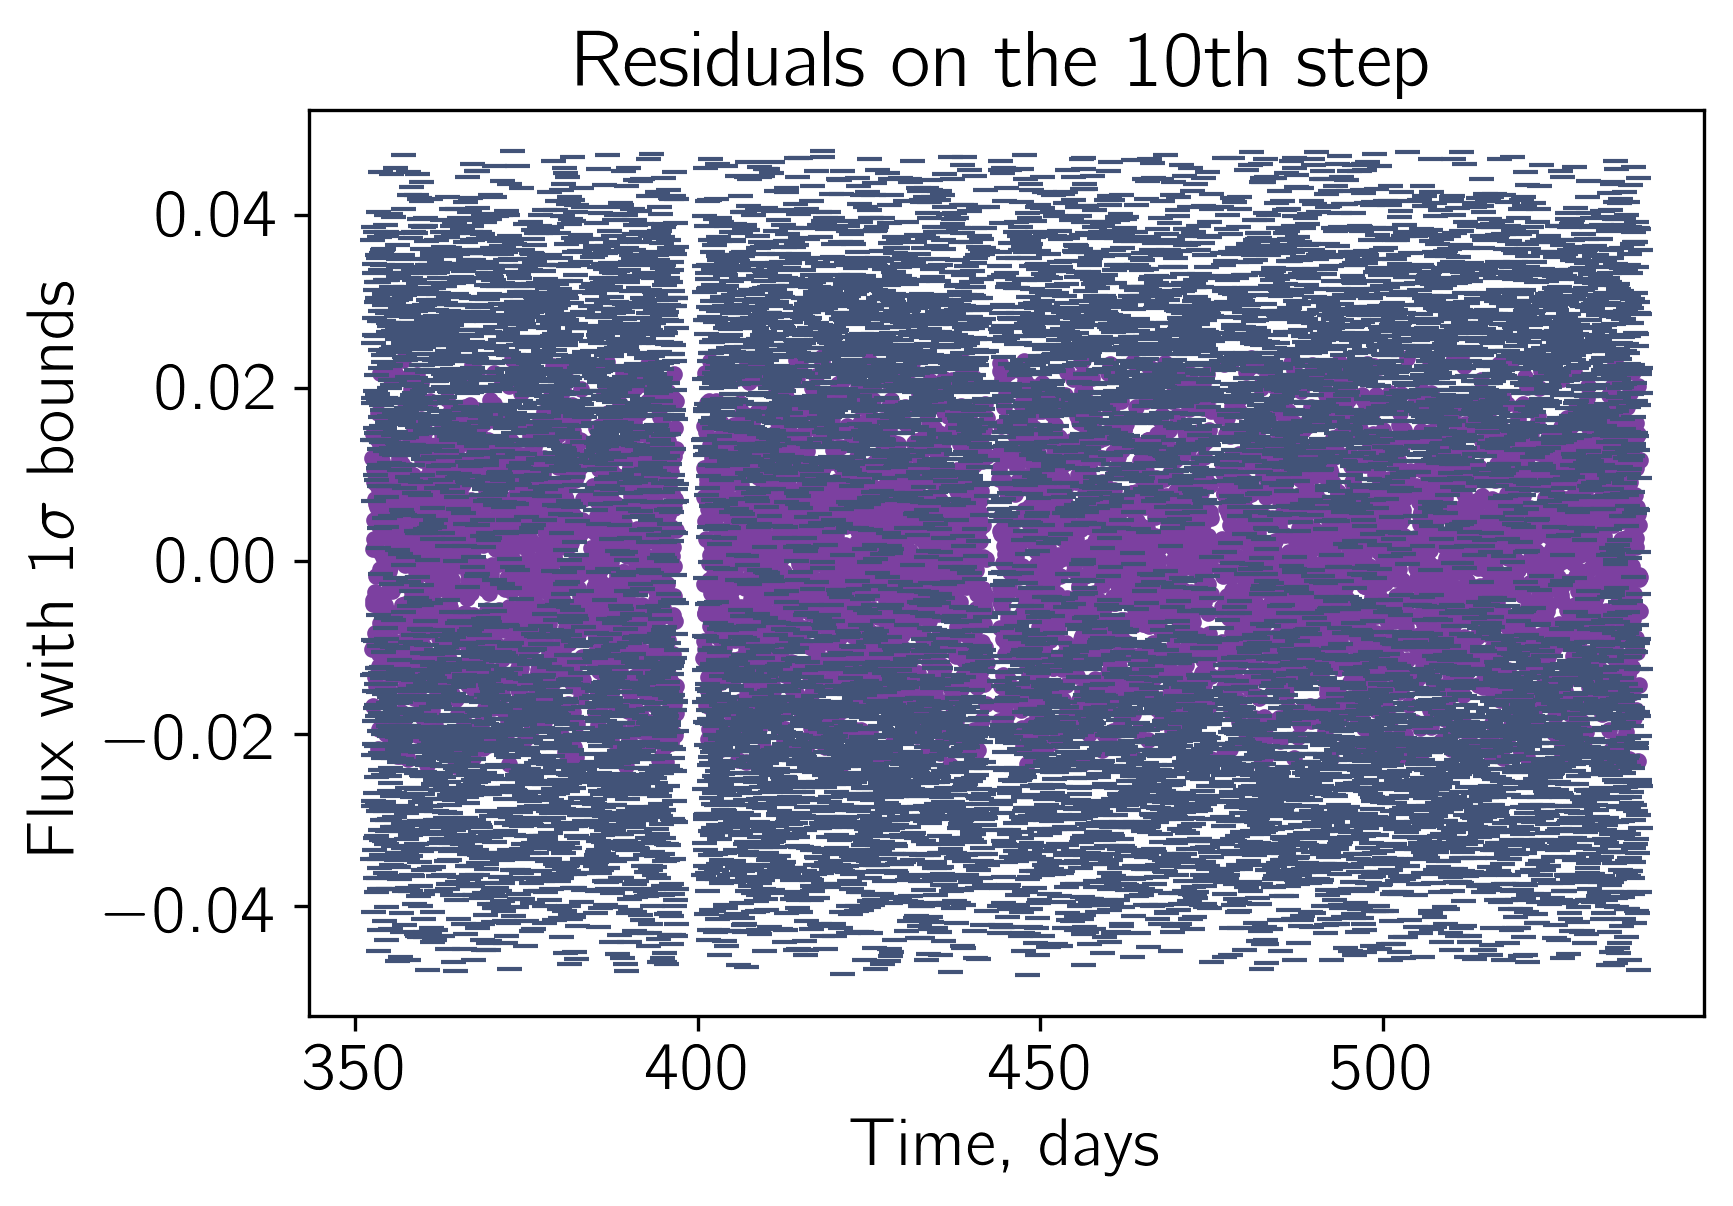

In [11]:
# Specifying a custom factor for standard deviation
sig_factor = 1

# A counter
k = 1

while True:

    print(hm.ordinal(k) + " step:\n")
    
    # Computing the extended form of the covariance matrix and factorizing
    gp.compute(t[sigma_mask], ferr[sigma_mask])
    
    # Minimizing the negative marginalized likelihood using the L-BFGS-B method
    opt = minimize(neg_log_like, init_params, jac=grad_neg_log_like, 
                   method="L-BFGS-B", bounds=bounds_values, args=(f, gp, sigma_mask))
    
    # Setting the new parameters
    gp.set_parameter_vector(opt.x)
    
    # Computing the conditional predictive distribution of the model 
    mu, var = gp.predict(f[sigma_mask], t, return_var=True)
    
    # Calculating standard deviation
    sig = np.sqrt(var + ferr ** 2)
    
    # Multiplying the standard deviation by a custom factor
    sig *= sig_factor
    
    # Calculating the residuals
    rds = f - mu
    
    # Calculating a new mask
    new_sigma_mask = np.abs(rds) < sig
    
    # Printing the results
    print_step()
    
    # Comparing the masks
    if np.all(new_sigma_mask == sigma_mask):
        break
    
    # Updating the mask
    sigma_mask = new_sigma_mask

    # Updating the counter
    k += 1